#DESAFÍO Nro. 5 NLP: análisis de sentimientos utilizando embeddings en redes neuronales LSTM.

Las modificaciones realizadas en relación con el ejercicio original fueron:

* Se modifica el dataset balanceando sus clases.
* Se agrega entrenamiento con embeddings Glove.
* Se agrega entrenamiento con embeddings FastText, pero complejizando la arquitectura.
* Se aumentan las epochs.
* Se aumenta la cantidad de palabras a mantener en el tokenizador.
* Se agregan gráficos de la función de pérdida.
* Se obtienen las conclusiones.


By Anahi Bazet

# Objetivo


El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador (cuántas estrellas le asigna al producto).

## 1 - Librerías

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
import numpy as np
import random
import io
import os
import gdown
import pickle
import logging
from pathlib import Path
from io import StringIO
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.utils.vis_utils import plot_model

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

## 2 - Obtención de datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas. Referencia del dataset: https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews

In [3]:
#Descargar el archivo del GD.
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 38.2MB/s]


In [4]:
# Leer el dataset.
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
print("Cantidad de críticas:", df.shape[0])

Cantidad de críticas: 23486


## 3 - Limpieza de datos
* Del dataset unicamente se van a utilizar las columnas "Review Text" y "Rating".
* Se transforma el rating 1-5 a una escala numérica de 0 a 4.

In [6]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head(5)

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [7]:
# Observar como está distribuido el dataset respecto a la columna Rating
# es decir, que tan balanceado se encuentra respecto a cada clase.
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

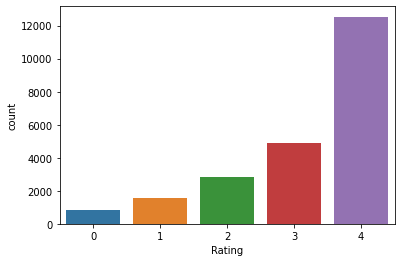

In [8]:
# Observar como está distribuido el dataset.
sns.countplot(x='Rating', data=df_reviews)
plt.show()

Se puede observar que el dataset está desbalanceado. Las críticas de las clases 0 y 1 se van a catalogar dentro de la clase 2. El dataset va a continuar con el desbalance, pero en menor medida.

In [9]:
from operator import xor
df_reviews['Rating'] = df_reviews['Rating'].apply(lambda x: 2 if x == 0 or x==1 else x).values

In [10]:
# Observar como está distribuido el dataset respecto a la columna Rating
# es decir, que tan balanceado se encuentra respecto a cada clase.
df_reviews['Rating'].value_counts()

4    12540
2     5193
3     4908
Name: Rating, dtype: int64

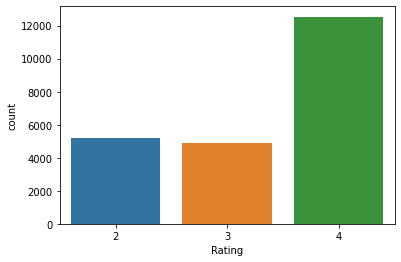

In [11]:
# Observar como está distribuido el dataset.
sns.countplot(x='Rating', data=df_reviews)
plt.show()

In [12]:
# Tomar la columna de las review y almacenarlo todo en un vector numpy.
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [13]:
# Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [14]:
# Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [15]:
# ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [16]:
# Utilizar "text_to_word_sequence" para separar las palabras en tokens.
# Recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase.
tokens = text_to_word_sequence(corpus)

In [17]:
# Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [18]:
# ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [19]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> el máximo número de palabras a mantener, basado en la frecuencia de la palabra.
# - Solo se mantienen las palabras más comunes: num_words-1
num_words = 14800
vocab_size = num_words
tok = Tokenizer(num_words=14800) 
tok.fit_on_texts(tokens)

In [20]:
# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario.
word_index = tok.word_index
len(word_index)

14847

In [21]:
# Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [22]:
sequences[0][:]

[253, 532, 917, 3, 662, 3, 68]

In [23]:
# Determinar cual es la oración más larga
maxlen=max(len(s) for s in sequences)
print (maxlen)

116


In [24]:
# Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia.

# Al realizar padding obtener la variable "X" (input).
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [25]:
# Rellena con ceros a la izquierda para que todas las sentencias tengan el mismo largo.
X[0][:]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0, 253, 532, 917,   3, 662,   3,  68],
      dtype=int32)

In [26]:
# Observar las dimensiones de la variable input.
X.shape

(22641, 116)

In [27]:
# Tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding.
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 3, luego de balancear).
y = df_reviews['Rating'].values
print(y.shape)
y_data_int_offset = y - 2
#La clase más baja comienza en 2 (2, 3 y 4)
y= to_categorical(y_data_int_offset, num_classes=3) 
print (y.shape)

(22641,)
(22641, 3)


In [28]:
# El primer elemento es de la clase 3.
y[0,:]

array([0., 1., 0.], dtype=float32)

In [29]:
# Dividir los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Determinar la dimensiones de entrada y salida.
in_shape = X_train.shape[1] # Las sentencias tienen 115 tokens (completados con padding).
out_shape = 3 # Clasificación multiclase.
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 116 , out_shape 3


## 4 - Entrenar el modelo con Embeddings + LSTM

Se entrenan embeddings propios.

In [31]:
model = Sequential()
# input_dim = vocab_size (max n_words).
# input_length = setencias con padding a 115.
# output_dim = 50 --> crear embeddings de tamaño 50.
# Se le suma 1 por el id del padding.
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
# Si miramos la capa de embedding en el resumen (summary):
# -none es el tamaño del batch, porque es dinámico.
# -115 es la cantidad de tokens de la secuencia.
# -50 es la tercera dimensión (tamaño del embedding de cada token).

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 116, 50)           740050    
                                                                 
 lstm (LSTM)                 (None, 116, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 116, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3

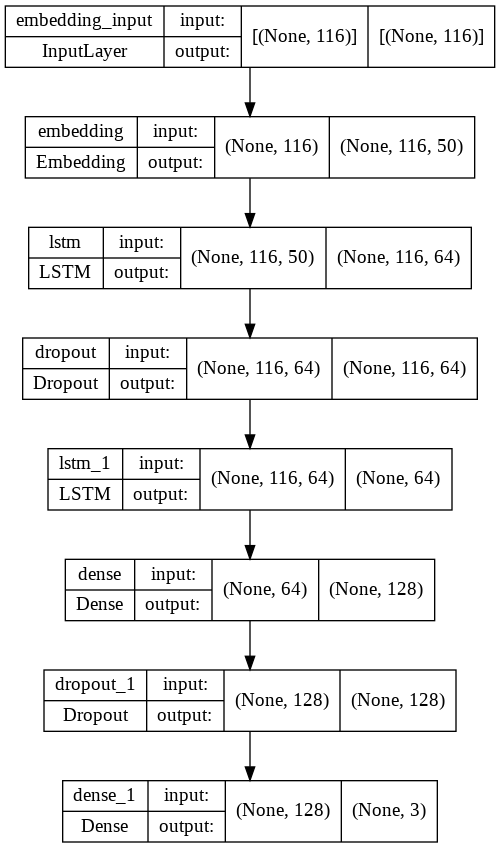

In [32]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
hist = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
453/453 [==============================] - 19s 18ms/step - loss: 0.7853 - accuracy: 0.6593 - val_loss: 0.7238 - val_accuracy: 0.6873
Epoch 2/20
453/453 [==============================] - 6s 14ms/step - loss: 0.6227 - accuracy: 0.7301 - val_loss: 0.6947 - val_accuracy: 0.7071
Epoch 3/20
453/453 [==============================] - 6s 13ms/step - loss: 0.5428 - accuracy: 0.7701 - val_loss: 0.7105 - val_accuracy: 0.6972
Epoch 4/20
453/453 [==============================] - 6s 13ms/step - loss: 0.4662 - accuracy: 0.8072 - val_loss: 0.8053 - val_accuracy: 0.7099
Epoch 5/20
453/453 [==============================] - 6s 14ms/step - loss: 0.4031 - accuracy: 0.8394 - val_loss: 0.8672 - val_accuracy: 0.6842
Epoch 6/20
453/453 [==============================] - 6s 14ms/step - loss: 0.3389 - accuracy: 0.8671 - val_loss: 0.9171 - val_accuracy: 0.6669
Epoch 7/20
453/453 [==============================] - 6s 13ms/step - loss: 0.2876 - accuracy: 0.8912 - val_loss: 1.0496 - val_accuracy: 0.650

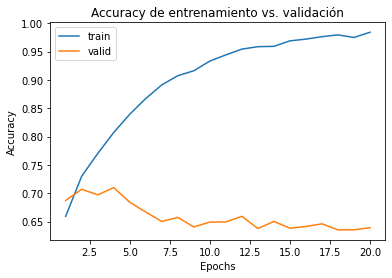

In [34]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
train_accuracy=hist.history['accuracy']
valid_accuracy=hist.history['val_accuracy']
sns.lineplot(x=epoch_count, y=train_accuracy, label='train')
sns.lineplot(x=epoch_count, y=valid_accuracy, label='valid')
plt.title("Accuracy de entrenamiento vs. validación")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

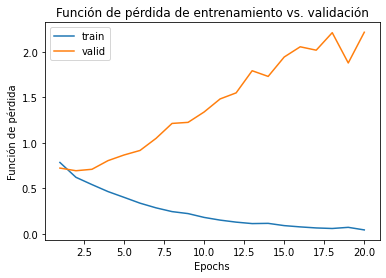

In [35]:
# Función de pérdida de entrenamiento vs. validación
loss_train=hist.history['loss']
loss_valid=hist.history['val_loss']
sns.lineplot(x=epoch_count, y=loss_train, label='train')
sns.lineplot(x=epoch_count, y=loss_valid, label='valid')
plt.title("Función de pérdida de entrenamiento vs. validación")
plt.ylabel("Función de pérdida")
plt.xlabel("Epochs")
plt.show()

In [36]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 1s 8ms/step - loss: 2.1833 - accuracy: 0.6491


[2.1832594871520996, 0.6491498947143555]

## 5 - Entrenar el modelo con Embeddings Fasttext + LSTM

Se utilizan embeddings FastText.

In [37]:
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:24<00:00, 117MB/s]


In [38]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Diccionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy structured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [39]:
model_fasttext = FasttextEmbeddings()

In [40]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
        #embedding_matrix es la matriz de embeddings.
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))
# print('number of null word embeddings:', len(words_not_found))
# Otra opción es la línea anterior comentada.

preparing embedding matrix...
number of null word embeddings: 2


In [41]:
Embedding(input_dim=vocab_size,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=in_shape, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)     # marcar como layer no entrenable

In [42]:
embed_dim

300

In [43]:
model2 = Sequential()
# input_dim = vocab_size (max n_words).
# input_length = setencias con padding a 115.
# output_dim = embed_dim (depende de cuáles embeddings preentrenados utilizamos).
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 116, 300)          4440000   
                                                                 
 lstm_2 (LSTM)               (None, 116, 64)           93440     
                                                                 
 dropout_2 (Dropout)         (None, 116, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                

In [44]:
hist2 = model2.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
453/453 [==============================] - 10s 16ms/step - loss: 0.9909 - accuracy: 0.5522 - val_loss: 0.9751 - val_accuracy: 0.5468
Epoch 2/20
453/453 [==============================] - 6s 14ms/step - loss: 0.9533 - accuracy: 0.5659 - val_loss: 0.9433 - val_accuracy: 0.5694
Epoch 3/20
453/453 [==============================] - 7s 15ms/step - loss: 0.9216 - accuracy: 0.5867 - val_loss: 0.9110 - val_accuracy: 0.5945
Epoch 4/20
453/453 [==============================] - 7s 15ms/step - loss: 0.8997 - accuracy: 0.5981 - val_loss: 0.9076 - val_accuracy: 0.6023
Epoch 5/20
453/453 [==============================] - 8s 17ms/step - loss: 0.8805 - accuracy: 0.6104 - val_loss: 0.8924 - val_accuracy: 0.6056
Epoch 6/20
453/453 [==============================] - 9s 20ms/step - loss: 0.8571 - accuracy: 0.6207 - val_loss: 0.8731 - val_accuracy: 0.6194
Epoch 7/20
453/453 [==============================] - 7s 16ms/step - loss: 0.8358 - accuracy: 0.6325 - val_loss: 0.8674 - val_accuracy: 0.624

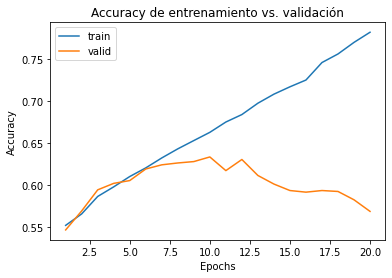

In [45]:
epoch_count_fasttext = range(1, len(hist2.history['accuracy']) + 1)
train_accuracy_fasttext=hist2.history['accuracy']
valid_accuracy_fasttext=hist2.history['val_accuracy']
sns.lineplot(x=epoch_count_fasttext, y=train_accuracy_fasttext, label='train')
sns.lineplot(x=epoch_count_fasttext, y=valid_accuracy_fasttext, label='valid')
plt.title("Accuracy de entrenamiento vs. validación")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

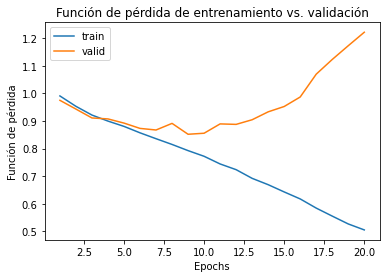

In [46]:
# Función de pérdida de entrenamiento vs. validación
loss_train_fasttext=hist2.history['loss']
loss_valid_fasttext=hist2.history['val_loss']
sns.lineplot(x=epoch_count_fasttext, y=loss_train_fasttext, label='train')
sns.lineplot(x=epoch_count_fasttext, y=loss_valid_fasttext, label='valid')
plt.title("Función de pérdida de entrenamiento vs. validación")
plt.ylabel("Función de pérdida")
plt.xlabel("Epochs")
plt.show()

In [47]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 1s 6ms/step - loss: 1.1974 - accuracy: 0.5803


[1.1974174976348877, 0.5802605152130127]

## 6 - Entrenar el modelo con Embeddings Fasttext + LSTM (con arquitectura más compleja)

Se utilizan embeddings FastText, pero complejizando la arquitectura de la red neuronal.

Se agrega una capa LSTM y se duplican las neuronas en las mismas. 

In [48]:
model4 = Sequential()
# input_dim = vocab_size (max n_words).
# input_length = setencias con padding a 115.
# output_dim = embed_dim (depende de cuáles embeddings preentrenados utilizamos).
model4.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model4.add(LSTM(units=128, return_sequences=True))
model4.add(Dropout(0.2))
model4.add(LSTM(units=128, return_sequences=True))
model4.add(Dropout(0.2))
model4.add(LSTM(units=128)) # La última capa LSTM no lleva return_sequences

model4.add(Dense(units=128, activation='relu'))
model4.add(Dropout(rate=0.2))
model4.add(Dense(units=out_shape, activation='softmax'))

model4.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 116, 300)          4440000   
                                                                 
 lstm_4 (LSTM)               (None, 116, 128)          219648    
                                                                 
 dropout_4 (Dropout)         (None, 116, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 116, 128)          131584    
                                                                 
 dropout_5 (Dropout)         (None, 116, 128)          0         
                                                                 
 lstm_6 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 128)              

In [49]:
hist4 = model4.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
453/453 [==============================] - 23s 40ms/step - loss: 0.9978 - accuracy: 0.5520 - val_loss: 0.9719 - val_accuracy: 0.5559
Epoch 2/20
453/453 [==============================] - 13s 29ms/step - loss: 0.9515 - accuracy: 0.5659 - val_loss: 0.9360 - val_accuracy: 0.5744
Epoch 3/20
453/453 [==============================] - 14s 31ms/step - loss: 0.9140 - accuracy: 0.5881 - val_loss: 0.9118 - val_accuracy: 0.5909
Epoch 4/20
453/453 [==============================] - 13s 28ms/step - loss: 0.8876 - accuracy: 0.6052 - val_loss: 0.8899 - val_accuracy: 0.6081
Epoch 5/20
453/453 [==============================] - 14s 30ms/step - loss: 0.8630 - accuracy: 0.6194 - val_loss: 0.8750 - val_accuracy: 0.6230
Epoch 6/20
453/453 [==============================] - 11s 24ms/step - loss: 0.8365 - accuracy: 0.6323 - val_loss: 0.8831 - val_accuracy: 0.6133
Epoch 7/20
453/453 [==============================] - 11s 24ms/step - loss: 0.8046 - accuracy: 0.6490 - val_loss: 0.8697 - val_accuracy:

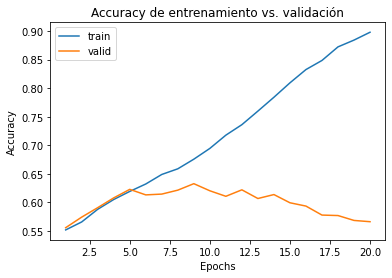

In [51]:
epoch_count_fasttext_arq = range(1, len(hist4.history['accuracy']) + 1)
train_accuracy_fasttext_arq=hist4.history['accuracy']
valid_accuracy_fasttext_arq=hist4.history['val_accuracy']
sns.lineplot(x=epoch_count_fasttext_arq, y=train_accuracy_fasttext_arq, label='train')
sns.lineplot(x=epoch_count_fasttext_arq, y=valid_accuracy_fasttext_arq, label='valid')
plt.title("Accuracy de entrenamiento vs. validación")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

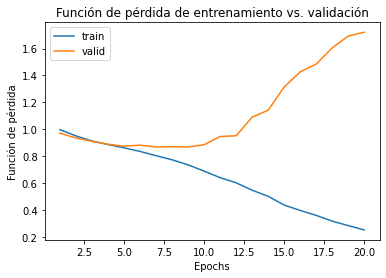

In [52]:
# Función de pérdida de entrenamiento vs. validación
loss_train_fasttext_arq=hist4.history['loss']
loss_valid_fasttext_arq=hist4.history['val_loss']
sns.lineplot(x=epoch_count_fasttext_arq, y=loss_train_fasttext_arq, label='train')
sns.lineplot(x=epoch_count_fasttext_arq, y=loss_valid_fasttext_arq, label='valid')
plt.title("Función de pérdida de entrenamiento vs. validación")
plt.ylabel("Función de pérdida")
plt.xlabel("Epochs")
plt.show()

In [53]:
model4.evaluate(X_test, y_test)

142/142 [==============================] - 1s 10ms/step - loss: 1.6774 - accuracy: 0.5752


[1.6774259805679321, 0.5751821398735046]

## 7 - Entrenar el modelo con Embeddings Glove + LSTM

Se utilizan embeddings Glove.

In [54]:
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:03<00:00, 153MB/s]


In [55]:
model_glove = GloveEmbeddings()

In [56]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 50 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_glove.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
        #embedding_matrix es la matriz de embeddings.
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))
# print('number of null word embeddings:', len(words_not_found))
# Otra opción es la línea anterior comentada.

preparing embedding matrix...
number of null word embeddings: 648


In [57]:
Embedding(input_dim=vocab_size,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=in_shape, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)     # marcar como layer no entrenable

In [58]:
model3= Sequential()
# input_dim = vocab_size (max n_words).
# input_length = setencias con padding a 115.
# output_dim = embed_dim (depende de cuáles embeddings preentrenados utilizamos).
model3.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model3.add(LSTM(units=64, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model3.add(Dense(units=128, activation='relu'))
model3.add(Dropout(rate=0.2))
model3.add(Dense(units=out_shape, activation='softmax'))

model3.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 116, 50)           740000    
                                                                 
 lstm_7 (LSTM)               (None, 116, 64)           29440     
                                                                 
 dropout_7 (Dropout)         (None, 116, 64)           0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                

In [59]:
hist3 = model3.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
453/453 [==============================] - 9s 14ms/step - loss: 0.9878 - accuracy: 0.5517 - val_loss: 0.9723 - val_accuracy: 0.5468
Epoch 2/20
453/453 [==============================] - 6s 13ms/step - loss: 0.9593 - accuracy: 0.5594 - val_loss: 0.9603 - val_accuracy: 0.5529
Epoch 3/20
453/453 [==============================] - 6s 12ms/step - loss: 0.9418 - accuracy: 0.5730 - val_loss: 0.9375 - val_accuracy: 0.5694
Epoch 4/20
453/453 [==============================] - 6s 12ms/step - loss: 0.9254 - accuracy: 0.5793 - val_loss: 0.9293 - val_accuracy: 0.5771
Epoch 5/20
453/453 [==============================] - 6s 12ms/step - loss: 0.9101 - accuracy: 0.5911 - val_loss: 0.9112 - val_accuracy: 0.5998
Epoch 6/20
453/453 [==============================] - 6s 12ms/step - loss: 0.8954 - accuracy: 0.5994 - val_loss: 0.9112 - val_accuracy: 0.5998
Epoch 7/20
453/453 [==============================] - 6s 12ms/step - loss: 0.8840 - accuracy: 0.6072 - val_loss: 0.9061 - val_accuracy: 0.5932

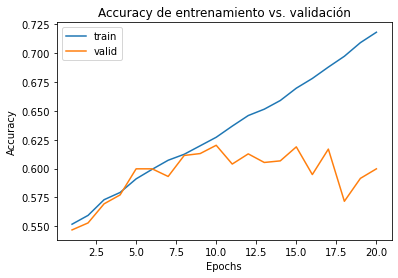

In [60]:
epoch_count_glove = range(1, len(hist3.history['accuracy']) + 1)
train_accuracy_glove=hist3.history['accuracy']
valid_accuracy_glove=hist3.history['val_accuracy']
sns.lineplot(x=epoch_count_glove, y=train_accuracy_glove, label='train')
sns.lineplot(x=epoch_count_glove, y=valid_accuracy_glove, label='valid')
plt.title("Accuracy de entrenamiento vs. validación")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

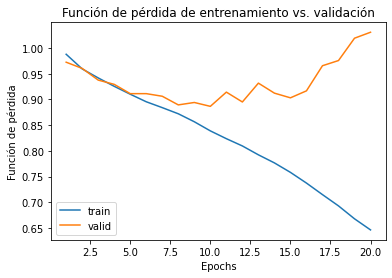

In [61]:
# Función de pérdida de entrenamiento vs. validación
loss_train_glove=hist3.history['loss']
loss_valid_glove=hist3.history['val_loss']
sns.lineplot(x=epoch_count_glove, y=loss_train_glove, label='train')
sns.lineplot(x=epoch_count_glove, y=loss_valid_glove, label='valid')
plt.title("Función de pérdida de entrenamiento vs. validación")
plt.ylabel("Función de pérdida")
plt.xlabel("Epochs")
plt.show()

In [62]:
model3.evaluate(X_test, y_test)

142/142 [==============================] - 1s 7ms/step - loss: 0.9915 - accuracy: 0.6143


[0.9914655089378357, 0.614263653755188]

## 8 - Conclusiones

A continuación se comparan las curvas de validación de la función de pérdida y de la métrica de accuracy para los siguientes cuatro modelos LSTM:

* Entrenando embeddings.
* Con embeddings pre-entrenados FastText.
* Con embeddings pre-entrenados FastText complejizando la arquitectura.
* Con embeddings pre-entrenados Glove.

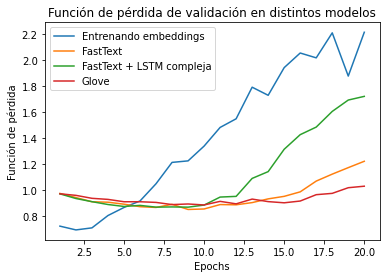

In [63]:
# Función de pérdida de validación en distintos modelos.
sns.lineplot(x=epoch_count, y=loss_valid, label='Entrenando embeddings')
sns.lineplot(x=epoch_count_fasttext, y=loss_valid_fasttext, label='FastText')
sns.lineplot(x=epoch_count_fasttext_arq, y=loss_valid_fasttext_arq, label='FastText + LSTM compleja')
sns.lineplot(x=epoch_count_glove, y=loss_valid_glove, label='Glove')
plt.title("Función de pérdida de validación en distintos modelos")
plt.ylabel("Función de pérdida")
plt.xlabel("Epochs")
plt.show()

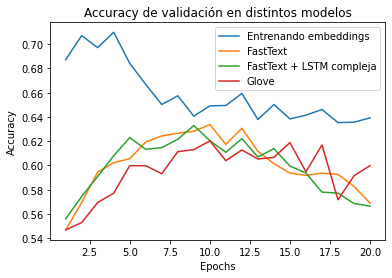

In [65]:
# Accuracy de validación en distintos modelos.
sns.lineplot(x=epoch_count, y=valid_accuracy, label='Entrenando embeddings')
sns.lineplot(x=epoch_count_fasttext, y=valid_accuracy_fasttext, label='FastText')
sns.lineplot(x=epoch_count_fasttext_arq, y=valid_accuracy_fasttext_arq, label='FastText + LSTM compleja')
sns.lineplot(x=epoch_count_glove, y=valid_accuracy_glove, label='Glove')
plt.title("Accuracy de validación en distintos modelos")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

Todos los modelos se llevaron a un punto en donde se produjo sobreentrenamiento, según se puede observar en la función de pérdida, ya que comienza a aumentar para la validación. No obstante, se puede ver en el gráfico de la métrica accuracy que alrededor de las epochs 9 y 10, los modelos que utilizaron embeddings de FastText y Glove alcanzan el valor máximo de la métrica, mientras que el modelo en donde se entrenaron los embeddings, lo hace en la epoch 4. Esos serían los puntos óptimos para cortar el entrenamiento, y en donde en realidad, habría que realizar la evaluación con el set de datos de pruebas.

El modelo que obtuvo la mejor performance, fue aquel en donde se entrenaron los embeddings, según se puede ver en el gráfico de métricas en donde alcanza 0.71 aprox. de accuracy, seguido por los modelos que utilizaron los embeddings de FastText (entre los cuales no hay diferencia marcada, a pesar de modificar la arquitectura de la red neuronal), y por último, el modelo de Glove. 

Es importante aclarar que se probaron otras combinaciones en la arquitectura, pero arrojaron siempre resultados en donde la métrica en el modelo que utiliza los embedings preentrenados de FastText, era peor que en el modelo en donde se entrenaron los embeddings propios. 